In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pathlib
from PIL import Image
import glob
import random
from collections import Counter

%matplotlib inline

In [4]:
# Kera Stuff
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Flatten, Activation, Dense, Dropout, Layer
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import vgg16
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


# Cat-Dog Classification
We are going to use pre-trained VGG16 model trained on imagenet.
Although, imagenet has cat and dog classes but they are of wider categories for species. We are only concerned 
with two classes instead of 1000 from imagenet. Instead of using Dense Layers for classifier network, we are going to use FCNN as described in later sections.  
<br/>
We are going to map some classes from imagenet to cat/dog and do some localization (very naive segmentation). This 
is done by plotting the heatmap of output layers we will get from Fully Convolutional Neural Network.

In [34]:
# image dimensions
WIDTH = 224
HEIGHT = 224
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 64
TEST_DIR = "/home/paradox/data/cat-dog/val/dog/*"

## Preprocessing for VGG16
Since original VGG16 was trained on BGR images along with mean subtraction, we are going to use corresponding 
preprocessing function in our data generator.  
```
- convert RGB to BGR
- Subtract Mean pixel values from imagenet -> IMG - [IMG_MEAN_RGB_VAL]
```

## Fully Convolutional Neural Network Model
Here, we build our own [FCNN](http://www.micc.unifi.it/bagdanov/pdfs/FCN-presentation.pdf) model using VGG16.
We discard all the dense layers and replace them with equivalent Conv layers that give output of same shape.  
So, the output layer will have a feature map equal to **number of classess**. Hence, we view the output (1, 1, c) 
along depth-wise to get the probability of corresponding class.
  
Instead of using Dense Layers, we are going to use Fully Convolutional Networks. So, we do **1x1** convolution.  
The layers before using (1,1) filters are all the same.  
<br/>
Since imagenet has 1000 classes, we will have output layer of shape (1, 1, 1000). The class probabilities can be 
viewed along final axis (depth).

### Create Custom Softmax Layer for final axis
We have to apply softmax along the final depth/axis. Standard Keras `Softmax` activation doesn't do that.

In [20]:
class Softmax4D(Layer):
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(Softmax4D, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        # use subtract max value for numerical stability
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    def get_output_shape_for(self, input_shape):
        return input_shape

#### Test Softmax
Sum of output values along last dimension (depth) should give 1 since probabilities are distributed after softmax 
activations.

In [21]:
# random data
data = np.random.random((10, 3, 4, 5))
data[0].sum(axis=-1)

array([[2.69613908, 3.09013482, 2.84594928, 2.5504813 ],
       [3.38753114, 2.74686607, 1.93956723, 3.34279679],
       [2.4254095 , 3.10061093, 1.2802335 , 3.43147798]])

In [22]:
# Just test if Softmax works along depth
model = Sequential([Softmax4D(input_shape=(3, 4, 5))])
model.predict(data)[0].sum(axis=-1)

array([[0.99999994, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        ],
       [0.99999994, 1.        , 0.99999994, 1.        ]], dtype=float32)

#### Note
Since, we are applying softmax along the depth, that is the final dimension/axis, the outputs after `Softmax4D` 
consists of 1 in every cell.

#### Build FCNN for VGG16
Here, we are going to make use of pre-trained VGG16 model (trained on Imagenet) for FCNN.  
We will also reshape the weights from `Dense` layers **fc1**, **fc2** and **predictions** 
to our convolutional layer accordingly.  
<br/>

**First Time**  
- If this is the first time, we will simply create model from `create_fcnn_from_vgg16` function.  
- We will pass input shape of (224, 224, 3) to create fcnn model here.
- In the function, it will first load VGG16 without classifier network(dense). On top of that, equivalent conv layers are added. This will create our FCNN model.
- Then, another VGG16 model is loaded that consists of classifier network (dense/fully connected).
- Reshape dense layers from original VGG16 into the shape of Conv layers we have added in FCNN.
- Save the the fcnn model for later use  

**Not a first time**  
We can totally skip calling `create_fcnn_from_vgg16` and proceed to **Object Localization** section where we will be loading our FCNN model for any input shape (WIDTH/HEIGHT).

In [23]:
def create_fcnn_from_vgg16(width, height, channels, num_class):
    # first create a FCNN
    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(width, height, channels))
    fcnn_model = Sequential()
    for layer in base_model.layers:
        fcnn_model.add(layer)
    fcnn_model.add(Conv2D(filters=4096, kernel_size=(7, 7), name='fc1', activation='relu')) # named to keras vgg16
    fcnn_model.add(Conv2D(filters=4096, kernel_size=(1, 1), name='fc2', activation='relu')) # named to keras vgg16
    fcnn_model.add(Conv2D(filters=1000, kernel_size=(1, 1), name='predictions')) # named to keras vg16
    fcnn_model.add(Softmax4D(axis=-1, name='softmax'))
        
    # now reshape dense layer weights to FCNN Kernel Weights
    # First Fetch original VGG16 with Dense Layers
    vgg_top = vgg16.VGG16(weights='imagenet', include_top=True, input_shape=(width, height, channels))
    for layer in fcnn_model.layers:
        # apply reshape to only fc1, fc2 and predictions layers
        if layer.name.startswith('fc') or layer.name.startswith('pred'):
            orig_layer = vgg_top.get_layer(layer.name)
            W, b = orig_layer.get_weights() # get original weights and bias
            ax1, ax2, previous_filter, n_filter = layer.get_weights()[0].shape
            new_W = W.reshape(ax1, ax2, -1, n_filter)
            layer.set_weights([new_W, b])
    del base_model
    del vgg_top
#     %reset base_model
    return fcnn_model

In [15]:
# uncomment following line if this is the first time creating FCNN model
fcnn_model = create_fcnn_from_vgg16(WIDTH, HEIGHT, channels=3, num_class=3)

In [16]:
# for the sake of clearing memory from jupyter
import gc; gc.collect()

148

In [17]:
# Uncomment this if this is the first time creating FCNN model
fcnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## Save Models

In [18]:
# Uncomment this if this is first time creating FCNN Model. This is where weights are saved for VGG16 FCNN model
# fcnn_model.save_weights('models/fcnn_vgg16_imagenet.h5')

## Load Weights

In [19]:
# fcnn_model.load_weights('models/fcnn_vgg16_imagenet.h5')

## Test Model
Here we are going to load a test image to seem model's prediction.

#### Load Image Manually

In [35]:
# testfiles = val_generator.filenames
testfiles = glob.glob(TEST_DIR)
len(testfiles), testfiles[:5]

(1000,
 ['/home/paradox/data/cat-dog/val/dog/dog.4064.jpg',
  '/home/paradox/data/cat-dog/val/dog/dog.4882.jpg',
  '/home/paradox/data/cat-dog/val/dog/dog.4713.jpg',
  '/home/paradox/data/cat-dog/val/dog/dog.4123.jpg',
  '/home/paradox/data/cat-dog/val/dog/dog.4194.jpg'])

/home/paradox/data/cat-dog/val/dog/dog.4841.jpg
/home/paradox/data/cat-dog/val/dog/dog.4841.jpg


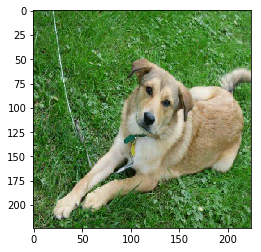

In [37]:
filename = random.choice(testfiles)
print(filename)
# filename = "/home/paradox/elephant.jpg"
print(filename)
img = load_img(filename, target_size=(WIDTH, HEIGHT))
img = np.array(img)
# img = load_img(filename)
# img = img.resize((WIDTH, HEIGHT), Image.BICUBIC)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


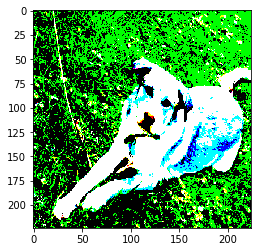

In [38]:
# preprocess for vgg16 model
img = vgg16.preprocess_input(img)
plt.imshow(img)

#### Expand Dims

In [39]:
img = np.array([img])
img.shape

(1, 224, 224, 3)

#### Predict

In [40]:
predictions = fcnn_model.predict(img)
predictions.shape

(1, 1, 1, 1000)

In [41]:
np.argmax(predictions, axis=-1)

array([[[207]]])

#### Map Class Id to Label

In [42]:
import json

In [43]:
with open('label_map.json') as f:
    idx_to_label = json.load(f)

In [44]:
idx = np.argmax(predictions, axis=-1).ravel()[-1]
idx_to_label[str(idx)]

'golden retriever'

# Object Localization
- Create Another ConvNN that takes 800x600 (width x height) image but all the kernels are same.  
- Final output will be (12, 19, 1000) instead of (1, 1, 1000) in the training model.  
- This (12, 19) gird will be used to determine the location of the cat/dog (objects) in the image.  
- This will result in class ids in each of the cells of (12,19) grid.
  
This is equivalent to using sliding window method, each slice taken as input to original model. So, we have to slide 
12x19 times i.e. 228 times and do 228 predictions for each slice. This is very inefficient since CNN is 
computation intensive.  
<br/>
Instead, doing a direct CNN on *800x600* is far more efficient since it predicts all the 228 slices in single forward pass.

In [45]:
TEST_WIDHT, TEST_HEIGHT = 800, 600

In [46]:
def create_localization_fcnn_vgg16(width, height, channels, num_class):
    # first create a FCNN
    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(width, height, channels))
    fcnn_model = Sequential()
    for layer in base_model.layers:
        fcnn_model.add(layer)
    fcnn_model.add(Conv2D(filters=4096, kernel_size=(7, 7), name='fc1', activation='relu')) # named to keras vgg16
    fcnn_model.add(Conv2D(filters=4096, kernel_size=(1, 1), name='fc2', activation='relu')) # named to keras vgg16
    fcnn_model.add(Conv2D(filters=1000, kernel_size=(1, 1), name='predictions')) # named to keras vg16
    fcnn_model.add(Softmax4D(axis=-1, name='softmax'))
    del base_model
    return fcnn_model

In [47]:
# model_localization = create_localization_model(TEST_WIDHT, TEST_HEIGHT, 3, 3)
model_localization = create_localization_fcnn_vgg16(TEST_HEIGHT, TEST_WIDHT, 3, 3)

In [48]:
import gc; gc.collect()

148

In [49]:
model_localization.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 600, 800, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 400, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 400, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 400, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 200, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 150, 200, 256)     295168    
__________

#### Load Kernel Weights
Since we are using same filters/kernels, we load the corresponding weights.

In [50]:
model_localization.load_weights("models/fcnn_vgg16_imagenet.h5")

In [51]:
## Uncomment following block if weights are not being loaded from h5 file but from fcnn_model generated above
# for i, layer in enumerate(fcnn_model.layers):
#     if type(layer) is Conv2D:
#         model_localization.layers[i].set_weights(layer.get_weights())

## Load Test Image

In [52]:
testfiles = glob.glob(TEST_DIR)
# files = val_generator.filenames
testfiles[:5]

['/home/paradox/data/cat-dog/val/dog/dog.4064.jpg',
 '/home/paradox/data/cat-dog/val/dog/dog.4882.jpg',
 '/home/paradox/data/cat-dog/val/dog/dog.4713.jpg',
 '/home/paradox/data/cat-dog/val/dog/dog.4123.jpg',
 '/home/paradox/data/cat-dog/val/dog/dog.4194.jpg']

/home/paradox/data/cat-dog/val/dog/dog.4976.jpg


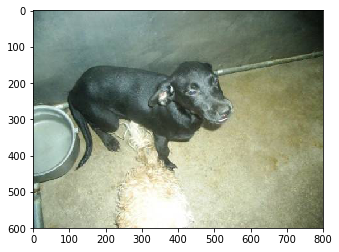

In [56]:
filename = random.choice(testfiles)
print(filename)
img = load_img(filename, target_size=(TEST_HEIGHT, TEST_WIDHT))
img = np.array(img)
# img = load_img(filename)
# img = img.resize((WIDTH, HEIGHT), Image.BICUBIC)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


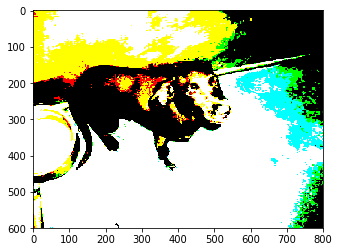

In [57]:
# preprocess for vgg16 model
img = vgg16.preprocess_input(img)
plt.imshow(img)

In [58]:
img = np.array([img])
img.shape

(1, 600, 800, 3)

#### Predict

In [59]:
predictions = model_localization.predict(img)
predictions.shape

(1, 12, 19, 1000)

In [60]:
# # since we are only predicting for single image, we can just take prediction from first index
# predictions = predictions[0]
# predictions.shape

In [61]:
# get grid size
r, c, n = predictions[0].shape
r, c, n

(12, 19, 1000)

In [63]:
# Count Class Ids for predictions
classes = np.argmax(predictions, axis=-1)
counter = Counter(classes.ravel())
counter.most_common()

[(179, 22),
 (268, 20),
 (246, 20),
 (196, 20),
 (208, 15),
 (618, 10),
 (198, 10),
 (909, 9),
 (344, 8),
 (567, 8),
 (34, 7),
 (111, 7),
 (103, 6),
 (451, 5),
 (885, 5),
 (150, 4),
 (395, 4),
 (205, 4),
 (216, 4),
 (228, 4),
 (58, 3),
 (346, 3),
 (78, 3),
 (360, 2),
 (587, 2),
 (137, 2),
 (341, 2),
 (715, 2),
 (633, 2),
 (623, 2),
 (202, 2),
 (6, 1),
 (777, 1),
 (235, 1),
 (242, 1),
 (816, 1),
 (551, 1),
 (220, 1),
 (267, 1),
 (4, 1),
 (203, 1),
 (190, 1)]

In [64]:
# Get Synset name for corresponding class ids predicted
res = [idx_to_label[str(elem)] for elem in classes.ravel() ]

In [65]:
counter = Counter(res)
counter.most_common()

[('Staffordshire bullterrier, Staffordshire bull terrier', 22),
 ('Mexican hairless', 20),
 ('Great Dane', 20),
 ('miniature schnauzer', 20),
 ('Labrador retriever', 15),
 ('ladle', 10),
 ('standard schnauzer', 10),
 ('wok', 9),
 ('hippopotamus, hippo, river horse, Hippopotamus amphibius', 8),
 ('frying pan, frypan, skillet', 8),
 ('leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea', 7),
 ('nematode, nematode worm, roundworm', 7),
 ('platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
  6),
 ('bolo tie, bolo, bola tie, bola', 5),
 ('velvet', 5),
 ('sea lion', 4),
 ('gar, garfish, garpike, billfish, Lepisosteus osseus', 4),
 ('flat-coated retriever', 4),
 ('clumber, clumber spaniel', 4),
 ('komondor', 4),
 ('water snake', 3),
 ('water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 3),
 ('tick', 3),
 ('otter', 2),
 ('hammer', 2),
 ('American coot, marsh hen, mud hen, water hen, Fulica americana', 2),
 ('hog, pig, grunter, 

#### Get List of Class Ids that represent DOG

In [66]:
# copied from somewhere else
dog_ids = [251, 268, 256, 253, 255, 254, 257, 159, 211, 210, 212, 214, 213, 216, 215, 219, 220, 221, 217, 218, 207, 209, 206, 205, 208, 193, 202, 194, 191, 204, 187, 203, 185, 192, 183, 199, 195, 181, 184, 201, 186, 200, 182, 188, 189, 190, 197, 196, 198, 179, 180, 177, 178, 175, 163, 174, 176, 160, 162, 161, 164, 168, 173, 170, 169, 165, 166, 167, 172, 171, 264, 263, 266, 265, 267, 262, 246, 242, 243, 248, 247, 229, 233, 234, 228, 231, 232, 230, 227, 226, 235, 225, 224, 223, 222, 236, 252, 237, 250, 249, 241, 239, 238, 240, 244, 245, 259, 261, 260, 258, 154, 153, 158, 152, 155, 151, 157, 156]

In [67]:
print("Total number of classes in Imagenet for dog :: ", len(dog_ids))

Total number of classes in Imagenet for dog ::  118


## Very Naive Image Segmentation
Now, here we are going to make use of classes 0/1 to fill in the **rxc** grid.  
This will act as a very naive image segmentatation.

In [68]:
####
# Use this code if output depth is 3.
# This will treat the predictions as RGB Image
####
# This might not be a good idea if num_class!=3
# plt.imshow(predictions)

## Build Heatmap

In [69]:
def build_heatmap(preds, class_ids):
    # First get prediction class ids
    pred_ids = np.argmax(preds, axis=-1)[0]
    # Now, check if predicion ids are actual class_ids -> If dog, class_ids represent dog ids from Imagenet
    return np.isin(pred_ids, class_ids)

In [70]:
heatmap = build_heatmap(predictions, dog_ids)
heatmap.shape

(12, 19)

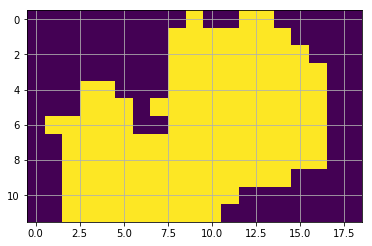

In [71]:
plt.imshow(heatmap)
plt.grid()

In [75]:
def build_heatmap2(preds, class_ids):
    return preds[0,:, :, class_ids].sum(axis=0)

In [76]:
heatmap2 = build_heatmap2(predictions, dog_ids)
heatmap2.shape

(12, 19)

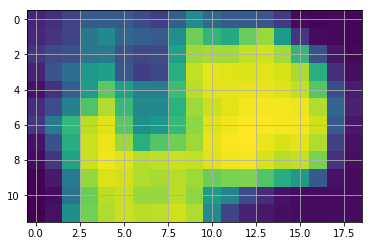

In [77]:
plt.imshow(heatmap2, interpolation='nearest', cmap="viridis")
plt.grid()